# Generate correlated fields

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.spatial.distance import pdist, squareform, cdist
from scipy import interpolate
%matplotlib inline
from jupyterthemes import jtplot # Requires jupytertheme
jtplot.style()
%config InlineBackend.figure_format = 'retina'
# print ("Packages loaded")

Leveraged kernel function

In [2]:
# Define a kernel function
def kernel_levse(_X1,_X2,_L1,_L2,_hyp={'gain':1,'len':1,'s2w':1e-8},_addS2w=False):
    hyp_gain = float(_hyp['gain'])**2
    hyp_len  = 1/float(_hyp['len'])
    s2w = _hyp['s2w']
    if len(_X1.shape)<=1: _X1=_X1.reshape((-1,1))
    if len(_X2.shape)<=1: _X2=_X2.reshape((-1,1))
    L = np.cos(np.pi/2*cdist(_L1,_L2,'euclidean'))
    pairwise_dists = cdist(_X1,_X2,'euclidean')
    K = hyp_gain*np.exp(-pairwise_dists ** 2/(hyp_len**2))
    K_Final = L*K
    if _addS2w:
        K_Final = K_Final + s2w*np.eye(K_Final.shape[0])
    return K_Final
# print ("Kernel function defined.")

Generated correlated fields

In [3]:
# Initialize a field
class field(object):
    def __init__(self,_name='field',_VERBOSE=False,
                 _axisInfo=np.array([0,10,0,10]),
                 _resFineInfo=np.array([100,100]),
                 _resCoarseInfo=np.array([20,20])
                ):
        # Parse inpus
        self.name = _name
        self.VERBOSE = _VERBOSE
        self.axisInfo = _axisInfo
        self.resFineInfo = _resFineInfo
        self.resCoarseInfo = _resCoarseInfo
        self.xMin,self.xMax,self.yMin,self.yMax \
            = self.axisInfo[0],self.axisInfo[1],self.axisInfo[2],self.axisInfo[3]
        self.xFineRes,self.yFineRes = self.resFineInfo[0],self.resFineInfo[1]
        self.xCoarseRes,self.yCoarseRes = self.resCoarseInfo[0],self.resCoarseInfo[1]
        # Get mesh
        self.xFineGrid = np.linspace(self.xMin,self.xMax,self.xFineRes)
        self.yFineGrid = np.linspace(self.yMin,self.yMax,self.yFineRes)
        self.xCoarseGrid = np.linspace(self.xMin,self.xMax,self.xCoarseRes)
        self.yCoarseGrid = np.linspace(self.yMin,self.yMax,self.yCoarseRes)
        self._xvFine,self._yvFine = np.meshgrid(self.xFineGrid,self.yFineGrid,sparse=False,indexing='ij')
        self._xvCoarse,self._yvCoarse = np.meshgrid(self.xCoarseGrid,self.yCoarseGrid,sparse=False,indexing='ij')
        self.xyFine = np.concatenate((self._xvFine.reshape((-1,1)),self._yvFine.reshape((-1,1))),axis=1)
        self.xyCoarse = np.concatenate((self._xvCoarse.reshape((-1,1)),self._yvCoarse.reshape((-1,1))),axis=1)
        self.lFine = np.zeros((self.xyFine.shape[0],1))
        self.lCoarse = np.zeros((self.xyCoarse.shape[0],1))
        self.zFine = np.zeros((self.xFineRes*self.yFineRes,1))
        self.zCoarse = np.zeros((self.xCoarseRes*self.yCoarseRes,1))
        self.nMeas = 0
        if self.VERBOSE:
            print ("[%s] instantiated"%self.name)
    def getMeasurements(self,_nMeas=10):
        self.nMeas = _nMeas
        self.fFineIntp = interpolate.interp2d(self.xFineGrid,self.yFineGrid,self.zFine.reshape(-1),kind='cubic')
        self.xyFineMeas = np.zeros((self.nMeas,2))
        self.zFineMeas = np.zeros((self.nMeas,1))
        for i in range(self.nMeas):
            xRand = self.xMin+(self.xMax-self.xMin)*np.random.rand()
            yRand = self.yMin+(self.yMax-self.yMin)*np.random.rand()
            zRand = self.fFineIntp(yRand,xRand)
            self.xyFineMeas[i,0] = xRand
            self.xyFineMeas[i,1] = yRand
            self.zFineMeas[i,0] = zRand
    
    # Plot
    def plotField(self,_figsize=(5,5),_title='field',_PLOT_COARSE=True,_PLOT_MEAS=False):
        fig = plt.figure(figsize=_figsize)
        if _PLOT_COARSE:
            # Plot coarse map
            p = plt.pcolormesh(self.xCoarseGrid,self.yCoarseGrid,
                            self.zCoarse.reshape(self.yCoarseRes,self.xCoarseRes),
                            vmin=-3,vmax=3)
        else:
            # Plot fine map
            p = plt.pcolormesh(self.xFineGrid,self.yFineGrid,
                     self.zFine.reshape(self.yFineRes,self.xFineRes),
                     vmin=-3,vmax=3)
            if _PLOT_MEAS:
                for j in range(self.nMeas):
                    xy = self.xyFineMeas[j,:]
                    z = self.zFineMeas[j,:]
                    plt.plot(xy[0],xy[1],'o',color='k')
                    ptxt = plt.text(0.3+xy[0],xy[1],'%.2f'%z,fontsize=10,
                                   horizontalalignment='left',verticalalignment='center')
                    ptxt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        plt.title('%s'%_title,fontsize=15)
        plt.axis('equal')
        # Colorbar
        cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
        fig.colorbar(p, cax=cbar_ax)
        
        
# Sensor field list
class fields(object):
    def __init__(self,_name='fields',_VERBOSE=False,
                 _axisInfo=np.array([0,10,0,10]),
                 _resFineInfo=np.array([100,100]),
                 _resCoarseInfo=np.array([20,20]),
                 _nField=10):
        # Parse inputs
        self.name = _name
        self.VERBOSE = _VERBOSE
        self.axisInfo = _axisInfo
        self.resFineInfo = _resFineInfo
        self.resCoarseInfo = _resCoarseInfo
        self.nField = _nField
        self.nPntInFineField = self.resFineInfo[0]*self.resFineInfo[1]
        self.nPntInCoarseField = self.resCoarseInfo[0]*self.resCoarseInfo[1]
        self.nTotalFinePnt = self.nField*self.nPntInFineField
        self.nTotalCoarsePnt = self.nField*self.nPntInCoarseField
        # Initialize fields 
        self.fields = [None]*self.nField
        for fIdx in range(self.nField):
            self.fields[fIdx] = field(_name='field%02d'%fIdx,_VERBOSE=self.VERBOSE,
                 _axisInfo=self.axisInfo,
                 _resFineInfo=self.resFineInfo,_resCoarseInfo=self.resCoarseInfo)
    # Get leverage parameters
    def genLevs(self,_nField,_oneRate,_rseed):
        np.random.seed(_rseed)
        levs = np.random.uniform(low=-1,high=+1,size=(_nField,1))
        levs[:int(math.ceil(_nField*_oneRate)),:] = 1.0
        levs = np.sort(levs,axis=0)[::-1]
        return levs
    
    # Make correlated fields
    def genCorrelatedFields(self,_levs,_rseed=0,_hyp={'gain':1,'len':1,'s2w':1e-8}):
        np.random.seed(_rseed)
        self.levs = _levs
        # Accumulate all Coarse inputs
        self.xyCoarseTotal = np.zeros((self.nTotalCoarsePnt,2))
        for fIdx in range(self.nField):
            self.xyCoarseTotal[fIdx*self.nPntInCoarseField:(fIdx+1)*self.nPntInCoarseField,:] \
                = self.fields[fIdx].xyCoarse
        # Sample correlated corse fields 
        self.lCoarseTotal = np.tile(self.levs,(1,self.nPntInCoarseField)).reshape((-1,1))
        self.K_CoarseTotal = kernel_levse(self.xyCoarseTotal,self.xyCoarseTotal,
                                    self.lCoarseTotal,self.lCoarseTotal,
                                    _hyp=_hyp,_addS2w=True)
        self.K_CoarseTotal = 0.5*(self.K_CoarseTotal+self.K_CoarseTotal.T)
        self.K_CoarseChol = np.linalg.cholesky(self.K_CoarseTotal)
        self.z_CoarseTotal = np.dot(self.K_CoarseChol,np.random.normal(size=self.nTotalCoarsePnt).reshape((-1,1)))
        for fIdx in range(self.nField):
            zCoarse = self.z_CoarseTotal[fIdx*self.nPntInCoarseField:(fIdx+1)*self.nPntInCoarseField,:] 
            self.fields[fIdx].zCoarse = zCoarse
            # Make fine fields
            currField = self.fields[fIdx]
            K_Tall = kernel_levse(currField.xyFine,currField.xyCoarse,
                                 currField.lFine,currField.lCoarse,
                                 _hyp=_hyp,_addS2w=False)
            K_Course = kernel_levse(currField.xyCoarse,currField.xyCoarse,
                                 currField.lCoarse,currField.lCoarse,
                                 _hyp=_hyp,_addS2w=True)
            self.fields[fIdx].zFine = np.matmul(np.matmul(K_Tall,np.linalg.inv(K_Course)),zCoarse)        

    # Get measurements
    def getMeasurements(self,_nMeas=10,_rseed=0):
        self.nMeasPerField = _nMeas
        np.random.seed(_rseed)
        for fIdx in range(self.nField):
            self.fields[fIdx].getMeasurements(_nMeas=self.nMeasPerField)
            
    # Accumulate measurements
    def getAccumulatedMeas(self):
        self.xyAcc = np.zeros((self.nField*self.nMeasPerField,2))
        self.zAcc = np.zeros((self.nField*self.nMeasPerField,1))
        self.A = np.zeros((self.nField*self.nMeasPerField,self.nField))
        for fIdx in range(self.nField):
            currField = self.fields[fIdx]
            self.xyAcc[fIdx*self.nMeasPerField:(fIdx+1)*self.nMeasPerField,:] \
                = currField.xyFineMeas
            self.zAcc[fIdx*self.nMeasPerField:(fIdx+1)*self.nMeasPerField,:] \
                = currField.zFineMeas
            self.A[fIdx*self.nMeasPerField:(fIdx+1)*self.nMeasPerField,fIdx] = 1  
            
    # Plot fields
    def plotFields(self,_figsize=(10,4),_rc=[1,1],_PLOT_COARSE=True,_PLOT_MEAS=False):
        fig, axs = plt.subplots(_rc[0],_rc[1],figsize=_figsize)
        for i, ax in enumerate(fig.axes):
            currField = self.fields[i]
            if _PLOT_COARSE:
                # Plot coarse map
                p = ax.pcolormesh(currField.xCoarseGrid,currField.yCoarseGrid,
                         currField.zCoarse.reshape(currField.yCoarseRes,currField.xCoarseRes),
                         vmin=-3,vmax=3)
            else:
                # Plot fine map
                p = ax.pcolormesh(currField.xFineGrid,currField.yFineGrid,
                         currField.zFine.reshape(currField.yFineRes,currField.xFineRes),
                         vmin=-3,vmax=3)
                if _PLOT_MEAS:
                    for j in range(currField.nMeas):
                        xy = currField.xyFineMeas[j,:]
                        z = currField.zFineMeas[j,:]
                        ax.plot(xy[0],xy[1],'o',color='k')
                        ptxt = ax.text(0.3+xy[0],xy[1],'%.2f'%z,fontsize=10,
                                       horizontalalignment='left',verticalalignment='center')
                        ptxt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
            ax.set_title('Lev:[%.2f]'%(self.levs[i]),fontsize=15)
            ax.axis('equal')
        # Colorbar
        cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
        fig.colorbar(p, cax=cbar_ax)

# print ("Class defined.")

Instantiate fields

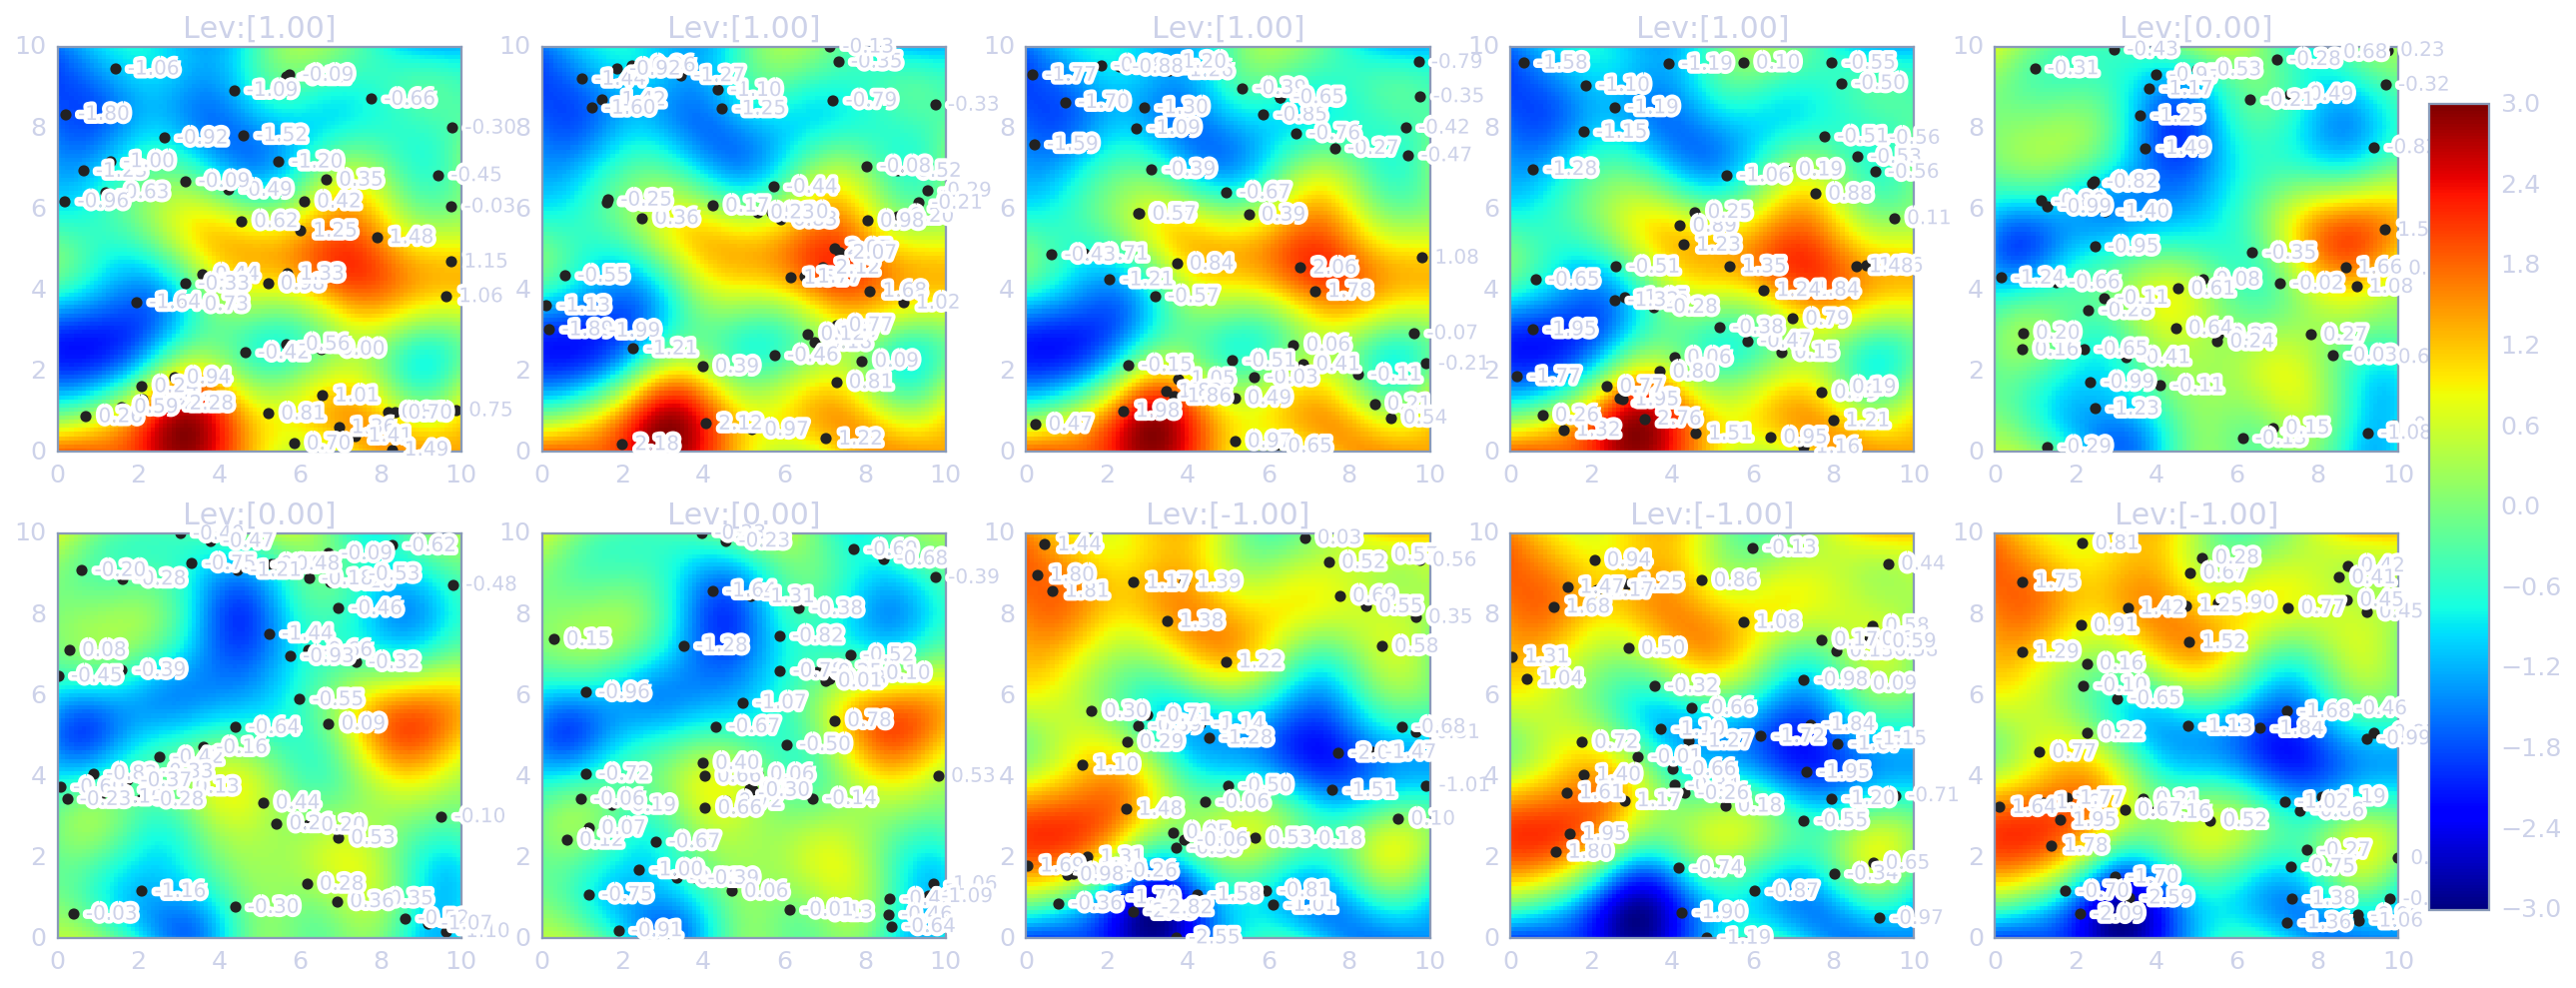

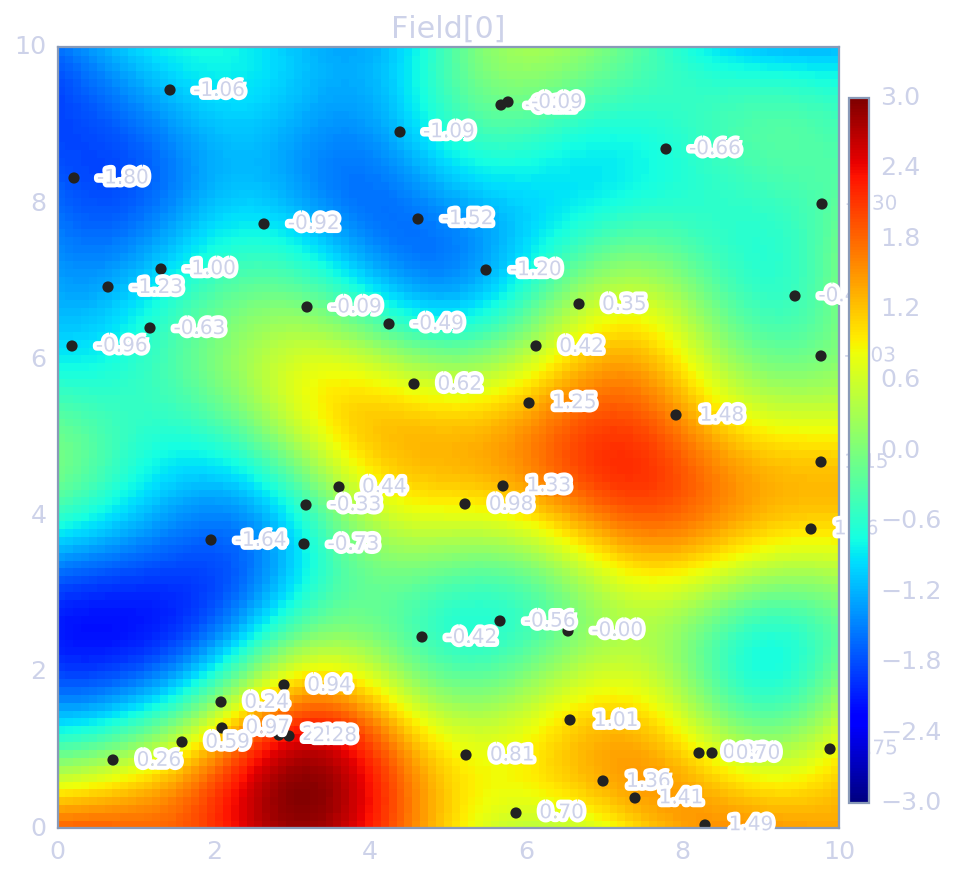

In [4]:
if __name__ == "__main__":
    # Instantiated fields
    F = fields(_name='fields',_VERBOSE=False,
               _axisInfo=np.array([0,10,0,10]),
               _resFineInfo=np.array([100,100]),
               _resCoarseInfo=np.array([20,20]),
               _nField=10)

    # Generated fields
    rseed = 0
    levs = np.array([[1,1,1,1,0,0,0,-1,-1,-1]]).astype(np.float).T
    hyp = {'gain':1,'len':1/2.,'s2w':1e-10}
    F.genCorrelatedFields(_levs=levs,_rseed=rseed,_hyp=hyp)

    # Get measurements from fields
    nMeasPerField = 50
    F.getMeasurements(_nMeas=nMeasPerField,_rseed=rseed)

    # Plot fields
    PLOT_MEAS = True
    F.plotFields(_figsize=(21,8),_rc=[2,5],_PLOT_COARSE=False,_PLOT_MEAS=PLOT_MEAS)

    # Accumulate measurements
    F.getAccumulatedMeas()
    
    # Plot a single field
    PLOT_MEAS = True
    F.fields[0].plotField(_figsize=(7,7),_title='Field[0]',_PLOT_COARSE=False,_PLOT_MEAS=PLOT_MEAS)
    